# CEBRA Embeddings

### Generates CEBRA embeddings from cleaned spike data 

- input: Cleaned/filtered spike data stored in a pickle file, containing datas and recordings
    - datas: list of tensors with neural acivity data
    - recordings: list of mouse ID labels
- output: CEBRA embedding pickle file (saved by name (mouse ID))

**Note:** This pipeline works on both CPU and GPU systems. Training will be faster on GPU but is not required.
Using example CEBRA embedding data files in ```/data/CEBRA_embedding_examples``` is recommened if no GPU available.

Author: @emilyekstrum
<br> 12/05/25

In [1]:
#load modules
# RUN ME
import cebra
import itertools
import os
import torch
import matplotlib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pickle as pkl
from cebra import CEBRA
from pathlib import Path

plt.style.use(['default', 'seaborn-v0_8-paper'])
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# Import TDA utilities
# RUN ME

import sys
from pathlib import Path

# add the repo root to path if needed
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository.")
    raise

# initialize or use the global data manager
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# print summary of available data
data_manager.print_summary()

Spike data already available.
Extracting persistence diagrams from all_dgms.zip
Extracted to: /Users/emilyekstrum/repos/TDA/data/all_dgms
TDA utilities loaded
TDA Data Manager Info
Workspace root: /Users/emilyekstrum/repos/TDA
Data directory: /Users/emilyekstrum/repos/TDA/data
  - clean_spike_data_zip: clean_spike_data.zip
  - clean_spike_data_dir: clean_spike_data
      Contains 8 .pkl files
  - cebra_examples: CEBRA_embedding_examples
      Contains 5 .pkl files
  - persistence_examples: persistence_diagram_examples
      Contains 22 .pkl files
  - all_dgms_zip: all_dgms.zip
  X all_dgms_dir: all_dgms

Available spike datasets (8):
  • LGN_chromatic_gratings.pkl
  • LGN_color_exchange.pkl
  • LGN_drifting_gratings.pkl
  • LGN_luminance_flash.pkl
  • V1_chromatic_gratings.pkl
  and 3 more


## 1. Load and inspect spike data files

In [3]:
# Load spike data
try:
    datas, recordings, dataset_info = data_manager.load_spike_data()
    
    print(f"\nDataset loaded")
    print(f"Dataset: {dataset_info['filename']}")
    print(f"Sessions: {dataset_info['n_sessions']}")
    
    # To load a specific dataset, use:
    # datas, recordings, dataset_info = data_manager.load_spike_data('LGNcolor_exchange.pkl')
    
except Exception as e:
    print(f"Could not load data: {e}")
    print("\nIf issue persists:")
    print("1. Make sure you're in the TDA repository")
    print("2. Check that data/clean_spike_data.zip exists")
    print("3. Or manually add .pkl files to data/clean_spike_data/")

Multiple datasets available:
  1. LGN_chromatic_gratings.pkl
  2. LGN_color_exchange.pkl
  3. LGN_drifting_gratings.pkl
  4. LGN_luminance_flash.pkl
  5. V1_chromatic_gratings.pkl
  6. V1_color_exchange.pkl
  7. V1_drifting_gratings.pkl
  8. V1_luminance_flash.pkl

Using the first one. To specify, use dataset_name parameter.
Loading data: LGN_chromatic_gratings.pkl
Loaded 3 recording sessions
  Sessions: ['C155', 'C159', 'C161']
  Data shape: torch.Size([136000, 15])

Dataset loaded
Dataset: LGN_chromatic_gratings.pkl
Sessions: 3


## 2. Train CEBRA
- GPU or CPU capabilities
- **SKIP STEP 2 TO USE INCLUDED EMBEDDING DATA**

## GPU
- args to edit:
    - ```dim``` - embedding dimension
    
### or skip and use example embeddings

In [49]:
train_steps = 30000
dim = 3 #embedding dimension 

single_session = dict()

print(f"Generating CEBRA embeddings with time-conditioned model for: {dataset_info['filename']}")

# use GPUs if avaiable, otherwise use CPU
if torch.cuda.is_available():
    device = 'cuda'
    print("using GPU (CUDA) for training")
else:
    device = 'cpu'
    print("using CPU for training")

cebra_time_model = CEBRA(model_architecture = 'offset10-model',
                        batch_size         = 512,
                        learning_rate      = 3e-4,
                        temperature        = 1,
                        output_dimension   = dim,
                        max_iterations     = train_steps,
                        num_hidden_units   = 128,
                        distance           = 'cosine',
                        conditional        = 'time', # time delta uses behavior/stimulus data to fit model
                        device             = device,
                        verbose            = True,
                        time_offsets       = 10,
                        optimizer          = 'adam',
                        )

# loop through sessions and train CEBRA models
for name, X in zip(recordings, datas):
    print(f"Training model for: {name}")
    single_session[name] = {}

    cebra_time_model.fit(X.type(torch.FloatTensor))
    cebra_time = cebra_time_model.transform(X.type(torch.FloatTensor))

    single_session[name]['model']      = cebra_time_model
    single_session[name]['embedding']  = cebra_time

    # save to pickle file
    region = dataset_info['filename'].split('_')[0]  # extract region from filename
    stim = dataset_info['filename'].split('_')[1] + "_" + dataset_info['filename'].replace('.pkl', '').split('_')[2]  # extract stimulus from filename
    output_filename = f"CEBRA_{dim}d_{region}_{stim}_{name}.pkl"  # file naming convention
    output_path = data_manager.get_output_path(output_filename, 'CEBRA_embedding_examples')

print(f"\nSaving CEBRA embeddings to: {output_path}")
with open(output_path, 'wb') as f:
    pkl.dump(single_session, f)

print(f"Output file: {output_filename}")

Generating CEBRA embeddings with time-conditioned model for: LGN_chromatic_gratings.pkl
using CPU for training
Training model for: C155


pos: -0.9348 neg:  7.1635 total:  6.2287 temperature:  1.0000:   0%|          | 20/30000 [00:04<1:51:01,  4.50it/s]


KeyboardInterrupt: 

# CPU
- reduced parameters
- args to edit:
    - ```dim``` - embedding dimension

### or skip and use example embeddings 

In [51]:
train_steps = 15000  # reduced iterations for faster training
dim = 3 #embedding dimension

single_session = dict()

print(f"Generating CEBRA embeddings with time-conditioned model for: {dataset_info['filename']}")

# force CPU usage and adjust parameters for CPU performance
device = 'cpu'

cebra_time_model = CEBRA(model_architecture = 'offset10-model',
                        batch_size         = 256,    # smaller batch size
                        learning_rate      = 3e-4,
                        temperature        = 1,
                        output_dimension   = dim,
                        max_iterations     = train_steps,
                        num_hidden_units   = 64,     # smaller hidden units
                        distance           = 'cosine',
                        conditional        = 'time',
                        device             = device,
                        verbose            = True,
                        time_offsets       = 10,
                        optimizer          = 'adam',
                        )

# loop through sessions and train CEBRA models
for name, X in zip(recordings, datas):
    print(f"Training model for: {name}")
    single_session[name] = {}
    cebra_time_model.fit(X.type(torch.FloatTensor))
    cebra_time = cebra_time_model.transform(X.type(torch.FloatTensor))
    single_session[name]['model']      = cebra_time_model
    single_session[name]['embedding']  = cebra_time
    
    # save to pickle file
    region = dataset_info['filename'].split('_')[0]  # extract region from filename
    stim = dataset_info['filename'].split('_')[1] + "_" + dataset_info['filename'].replace('.pkl', '').split('_')[2]  # extract stimulus from filename
    output_filename = f"CEBRA_{dim}d_{region}_{stim}_{name}.pkl"  # file naming convention
    output_path = data_manager.get_output_path(output_filename, 'CEBRA_embedding_examples')

print(f"\nSaving CEBRA embeddings to: {output_path}")
with open(output_path, 'wb') as f:
    pkl.dump(single_session, f)

print(f"Output file: {output_filename}")

Generating CEBRA embeddings with time-conditioned model for: LGN_chromatic_gratings.pkl
Training model for: C155


pos: -0.6247 neg:  5.7868 total:  5.1620 temperature:  1.0000: 100%|██████████| 15000/15000 [18:11<00:00, 13.74it/s]


Training model for: C159


pos: -0.9817 neg:  5.7165 total:  4.7348 temperature:  1.0000: 100%|██████████| 15000/15000 [25:30<00:00,  9.80it/s]


Training model for: C161


pos: -0.7839 neg:  5.7263 total:  4.9424 temperature:  1.0000: 100%|██████████| 15000/15000 [24:23<00:00, 10.25it/s]



Saving CEBRA embeddings to: /Users/emilyekstrum/repos/TDA/data/CEBRA_embedding_examples/CEBRA_3d_LGN_chromatic_gratings_C161.pkl
Output file: CEBRA_3d_LGN_chromatic_gratings_C161.pkl


## 3. Load in CEBRA model & embedding from pickle file
- use example data file or previously trained model

- args to edit:
    - ```model_path = cebra_files[i]``` - change i to index of file to plot
        - run cell once to see file indices 

In [6]:
try:
    # find available CEBRA embedding files in data/CEBRA_embedding_examples/
    cebra_files = data_manager.find_files("*.pkl", "cebra_examples")

    print(f"\n{len(cebra_files)} CEBRA embedding files.")
    for f in cebra_files:
        print(f"    {f.name} \n         - access with index {cebra_files.index(f)} in model_path variable")
    
    if cebra_files:
        # use the first available file or specifiy by index
        model_path = cebra_files[1] # change index to load different files

        print(f"\nLoading CEBRA embedding file: {model_path.name}\n")
        
        # load with CPU mapping for compatibility
        from tda_utils import load_cebra_model
        
        # always force CPU loading to avoid CUDA compatibility issues
        print("Loading model with CPU mapping for compatibility")
        loaded_sessions_cpu, device_info = load_cebra_model(model_path, force_cpu=True)
        
        print(f"Loaded model on: {device_info}")
        print(f"Available sessions: {list(loaded_sessions_cpu.keys())}")
        
        # make the loaded sessions available for plotting
        single_session = loaded_sessions_cpu
        
    else:
        print("No CEBRA models found in data/CEBRA_embedding_examples/")
        print("Either:")
        print("1. Train a model first using the training cells above or")
        print("2. Check that example embedding files are present in the data folder")
        
except Exception as e:
    print(f"Error loading model: {e}")


5 CEBRA embedding files.
    V1_3d_CEBRA_unsup_time_color_exchange.pkl 
         - access with index 0 in model_path variable
    V1_8d_CEBRA_unsup_time_color_exchange.pkl 
         - access with index 1 in model_path variable
    LGN_3d_CEBRA_unsup_time_color_exchange.pkl 
         - access with index 2 in model_path variable
    LGN_8d_CEBRA_unsup_time_color_exchange.pkl 
         - access with index 3 in model_path variable
    CEBRA_3d_LGN_chromatic_gratings_C161.pkl 
         - access with index 4 in model_path variable

Loading CEBRA embedding file: V1_8d_CEBRA_unsup_time_color_exchange.pkl

Loading model with CPU mapping for compatibility
Loading model: Using CPU
CUDA compatibility issue detected, forcing CPU mapping
loaded using CPU unpickler
moving d4 model from cuda:0 to cpu
Loaded model on: Using CPU
Available sessions: ['d4', 'd5', 'd6', 'C153', 'C155', 'C159', 'C160', 'C161']


/opt/anaconda3/lib/python3.13/site-packages/torch/_weights_only_unpickler.py:552: UserWarning: Detected pickle protocol 4 in the checkpoint, which was not the default pickle protocol used by `torch.load` (2). The weights_only Unpickler might not support all instructions implemented by this protocol, please file an issue for adding support if you encounter this.
  warnings.warn(


In [7]:
# RUN ME 
# utils for embedding analysis 

def downsample_embedding(embed, n_target=1000, method="fps", seed=42):
    """ Downsample an embedding to n_target points using farthest pont sampling or random sampling
    
    Args:
        embed : np.ndarray input embedding of shape (N, D).
        n_target : int target number of points after downsampling.
        method : str downsampling method: "random" or "fps" (farthest point sampling).

    Returns:
        np.ndarray: Downsampled embedding of shape (n_target, D).
    """

    N = embed.shape[0]
    if n_target >= N:
        return embed  # nothing to downsample
    
    rng = np.random.default_rng(seed)

    if method == "random":
        idx = rng.choice(N, size=n_target, replace=False)
        return embed[idx]

    #farthest point sampling
    elif method == "fps":
        idxs = [rng.integers(N)]
        dists = np.linalg.norm(embed - embed[idxs[0]], axis=1)

        for _ in range(1, n_target):
            next_idx = np.argmax(dists)
            idxs.append(next_idx)
            new_dists = np.linalg.norm(embed - embed[next_idx], axis=1)
            dists = np.minimum(dists, new_dists)

        return embed[idxs]

    else:
        raise ValueError("method must be 'random' or 'fps'")


def plot_3d_CEBRA(session_dict, session_names, ncols=4):
    """ Plot 3D CEBRA embeddings from session dictionary
    Args:
        session_dict : dict containing session data with embeddings
        session_names : list of session names
        ncols : int number of columns in the plot grid. """
    
    region = model_path.stem.split('_')[0]  # extract region from filename
    dim = model_path.stem.split('_')[1]  # extract dimension from filename
    stim = model_path.stem.split('_')[2]  # extract stimulus from filename
    
    n = len(session_names)
    n_rows = int(np.ceil(n/ncols))

    fig = plt.figure(figsize=(20, 4))

    for n, name in enumerate(session_names):
        embedding = session_dict[name]['embedding']
        
        # first row is default view
        ax = plt.subplot2grid((2, 8), (0, n), projection='3d')
        ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], s=5, alpha=0.3,
                   cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True)
        ax.set_title(name, y=0.8)
        ax.view_init(elev=20, azim=45)  # default view
        
        # second row is 180 deg rotated view
        ax = plt.subplot2grid((2, 8), (1, n), projection='3d')
        ax.scatter(embedding[:,0],
                embedding[:,1],
                embedding[:,2],
                s=5, alpha=0.3,
                cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
                )
        ax.view_init(elev=20, azim=225)  

    for axs in fig.get_axes():
        axs.axis('off')
        axs.grid(False)
        axs.xaxis.pane.fill = False
        axs.yaxis.pane.fill = False
        axs.zaxis.pane.fill = False
        axs.xaxis.pane.set_edgecolor('w')
        axs.yaxis.pane.set_edgecolor('w')
        axs.zaxis.pane.set_edgecolor('w')

    # row labels 
    if len(session_names) > 0:
        fig.text(0.02, 0.7, 'Default\nView', fontsize=12, 
                ha='center', va='center')
        fig.text(0.02, 0.25, '180°\nRotation', fontsize=12, 
                ha='center', va='center')
    
    sm = plt.cm.ScalarMappable(cmap='hsv')
    sm.set_array([])
    
    # colorbar
    cbar_ax = fig.add_axes([0.97, 0.15, 0.008, 0.7]) 
    
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.ax.set_title('Normalized Time\nAcross Trials', pad=10)

    plt.subplots_adjust(wspace=0, hspace=0, right=0.94)  
    plt.suptitle(f'CEBRA Time Embeddings - {region} {stim} {dim}', fontsize=20)
    plt.tight_layout()
    plt.show()

# 4. Plot embeddings

Using loaded sessions: ['d4', 'd5', 'd6', 'C153', 'C155', 'C159', 'C160', 'C161']


/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_80455/923885534.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


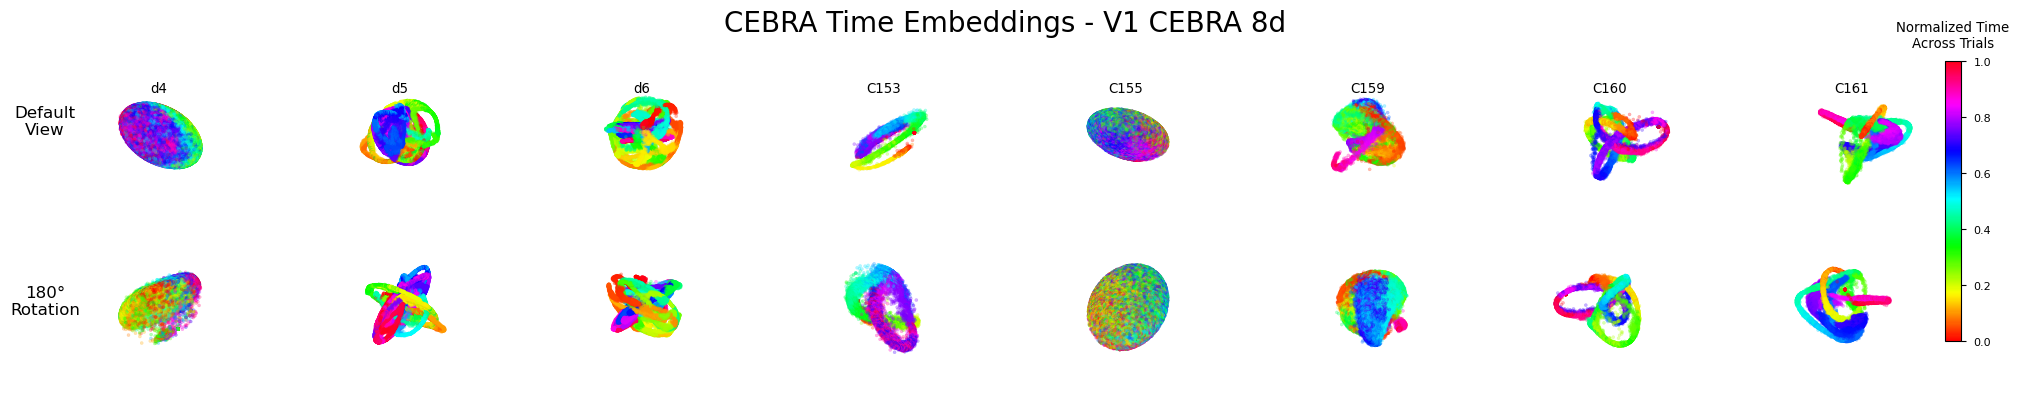

In [8]:
try:
    # check loaded sessions available
    if 'single_session' in locals() and single_session:
        print(f"Using loaded sessions: {list(single_session.keys())}")
        session_dict = single_session
        session_names = list(single_session.keys())
        plot_3d_CEBRA(session_dict, session_names)
        
    else:
        # find and load CEBRA embedding files
        available_embeddings = data_manager.find_files("*.pkl", "cebra_examples")
        
        if available_embeddings:
            print(f"Found {len(available_embeddings)} CEBRA embedding files:")
            for i, path in enumerate(available_embeddings[:5], 1):  # show first 5
                print(f"  {i}. {path.name}")
            
            # use first available embedding file
            embedding_path = available_embeddings[0]
            print(f"\nAttempting to load: {embedding_path.name}")
            
            # load with CPU mapping to avoid CUDA issues
            session_dict, session_names = data_manager.load_embedding_data(embedding_path, force_cpu=True)
            print(f"Successfully loaded and plotting embeddings")

            # plot embeddings
            plot_3d_CEBRA(session_dict, session_names)
            
        else:
            print("No CEBRA embedding files found.")
            print("To fix this issue:")
            print("1. Run one of the training cells above to generate new embeddings")
            print("2. Choose either GPU or CPU training based on your system")
            print("3. Then re-run this plotting cell")
        
except Exception as e:
    print(f"Error plotting embeddings: {e}")
    print("This might be a CUDA/CPU compatibility issue.")
    print("To fix this issue:")
    print("Use the 'Train CEBRA - CPU' cell above to create new embeddings then re-run this cell")

**NOTE:** embedding files in ```TDA/data/CEBRA_embedding_examples``` and in all subsequent data files were selected based on if the embeddings had "shape" or not. This means that the embedding did not look like a shuffled model. <br> <br> This embedding selection process was highly SUBJECTIVE, but potentially a step that could be systematically determined using some sort of embedding structure-ality metric.